# RSNA-STR Pulmonary Embolism Detection Data Understanding and EDA

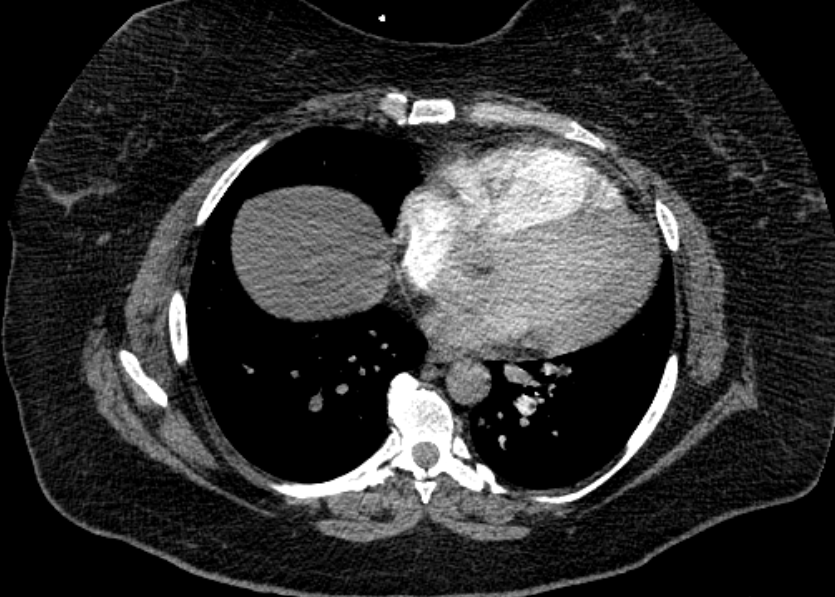

# General Information:

A pulmonary embolism (PE) is caused by an artery blockage in the lung. It is time consuming to confirm a PE and prone to overdiagnosis. Machine learning could help to more accurately identify PE cases.

It is among the most fatal cardiovascular diseases. Timely and accurate diagnosis will help these patients receive better care.

In this competition, you’ll detect and classify PE cases. In particular, you'll use chest CTPA images.







# Metric:

The metric used in this competition is **weighted log loss**. It is weighted to account for the relative importance of some labels. 




***Exam-level weighted log loss:***
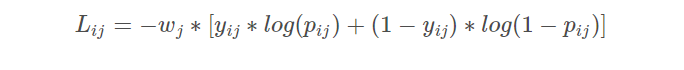

***Image Level Weighted Loss:***
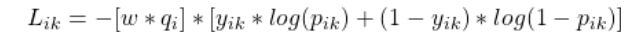

Their are 9 study-level labels and 1 image-level labels

A **binary log loss equation** for each label is taken and then  the mean of the log loss over all labels is calculated.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os 
%matplotlib inline
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from os import listdir, mkdir
import pydicom
import scipy.ndimage
import pydicom as dcm
import imageio
import tqdm as tqdm
import glob
from PIL import Image
from IPython.display import HTML


# **Data overview**

This competition has unique and interesting data, let's analyze it.

**SOPInstanceUID** => Is an Unique identifier associated with an Image
 
**StudyInstanceUID SeriesInstanceUID SOPInstanceUID** => This Columns are used just for locating the dcm File


    

In [ ]:
train = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/train.csv")
test = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/test.csv")
sub = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/sample_submission.csv")


In [ ]:
train.shape , test.shape, sub.shape 

Train has (3 UID's) and the remaining are features and Target labels . 

Test has 3 columns and all those are the 3 UID's

In [ ]:
train.head()

In [ ]:
train.nunique()

All the Features except the 3 UID , have binary labels associated with them either(0,1)

  **Image Level Features :**

1. **pe_present_on_image** => Tells Whether their is any formation of Pulmonary Embolism in the Image.( 0 - No "PE" , 1- "PE" formation)

 **Informational Features :**

This Features are Informational and ***Does not*** require any Predictions.

1. **qa_motion** => indicates whether radiologists noted an issue with **motion** in the study . Also Binary (0 or 1)
2. **qa_contrast** => indicates whether radiologists noted an issue with **Contrast** in the study
3. **flow_artifact** 
4. **true_filling_defect_not_pe**  => Not a PE Defect

 **Exam Level Features** :

All Labels are binary Labels

Weights Mentioned are Used while **Calculating the Weighted Log Loss**: 

1. **negative_exam_for_pe** => images in the study that have PE present , Weight Associated for Loss => **0.0736196319**
2. **rv_lv_ratio_gte_1**  =>  whether the RV/LV ratio present in the study is** >= 1** , Weight Associated for Loss => **0.2346625767 **
3. **rv_lv_ratio_lt_1** => Whether ration **RV/LV is <1** , Weight Associated for Loss => **0.0782208589**
4. **leftsided_pe** => Indication of PE present on **Left side of Image** , Weight Associated for Loss => **0.06257668712**
5. **rightsided_pe** => Right Sided PE , Weight Associated for Loss => **0.06257668712**
6. **chronic_pe** => If PE** persistant for Long time **then Chronic PE , Weight Associated for Loss => 0.1042944785
7. **acute_and_chronic_pe**  => if PE present is **both acute & chronic**   , Weight Associated for Loss => **0.1042944785**
8. **central_pe** => center of Image PE , Weight Associated for Loss => **0.1877300613**
9. **indeterminate** = > If** not able to create the necessary Exam Labels** then flag this to 1 , Weight Associated for Loss => **0.09202453988**






# What are we Predicting :

The Output Format Should be **4 Labels** associated with **Every Unique Image UID **.

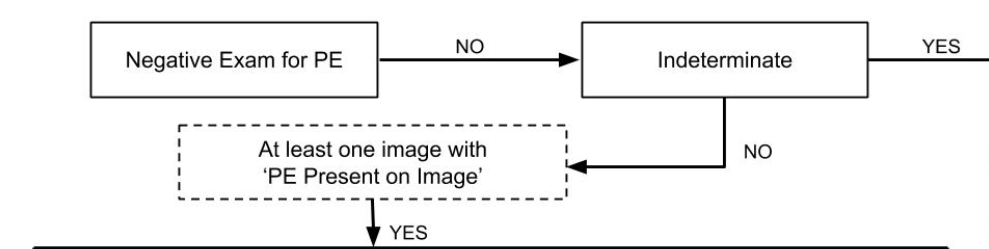

The 4 Labels to Predict Are :

This 4 labels are divided into 2 Groups namely (Yes-Indeterminate) & (No-InDeterminate) , ie. If set of exam labels for an image could not be created it goes into Indeterminate group . 

**If NOt Indeterminate:**

1. Location Label (Atleast 1) : rightsided_pe,leftsided_pe,central_pe

2. (RL/LV) Ratio (Only 1 Label) : (>=1) or (<1)
 
3. Type of PE (Only 1) : Chronic_pe ,acute_and_chronic_pe . If Both are not then only Acute PE

**If Indeterminate:**

1. The QA Label are responsible for not able to determine the PE ( Atleast 1 QA Label) : qa_contrast,qa_motion


In [ ]:
files = glob.glob('../input/rsna-str-pulmonary-embolism-detection/train/*/*/*.dcm')

In [ ]:
features = []
for i in train.columns:
    features.append(i)
features = features[3:]
print(features)
print(len(features))

In [ ]:

fig,ax = plt.subplots(3,5,figsize=(15,15))
sns.countplot(train['pe_present_on_image'],ax=ax[0][0],)
sns.countplot(train['negative_exam_for_pe'],ax=ax[0][1])
sns.countplot(train['qa_motion'],ax=ax[0][2])
sns.countplot(train['qa_contrast'],ax=ax[0][3])
sns.countplot(train['flow_artifact'],ax=ax[1][0])
sns.countplot(train['rv_lv_ratio_gte_1'],ax=ax[1][1])
sns.countplot(train['rv_lv_ratio_lt_1'],ax=ax[1][2])
sns.countplot(train['leftsided_pe'],ax=ax[1][3])
sns.countplot(train['chronic_pe'],ax=ax[1][4])
sns.countplot(train['true_filling_defect_not_pe'],ax=ax[2][0])
sns.countplot(train['rightsided_pe'],ax=ax[2][1])
sns.countplot(train['acute_and_chronic_pe'],ax=ax[2][2])
sns.countplot(train['central_pe'],ax=ax[2][3])
sns.countplot(train['indeterminate'],ax=ax[2][4])


Almost All the counts seemed to be skewed . So high imbalance among the PE positive and PE negative could be seen

In [ ]:
train.info()

In [ ]:
test.head()
print(f" Total predictions to be Done in test set are {test.shape[0]} samples")

In [ ]:
print('Null values in train data:',train.isnull().sum().sum())
print('Null values in test data:',test.isnull().sum().sum())

Lets Checkout the Tranining Features for 1 sample Image

In [ ]:
sample = train.iloc[0]
sample

# Lets Analayze the output's Done for this Sample Image 
# 
As **Indeterminate == 0** we Compute this output Labels Only 

1. rv_lv_ratio_lt_1  => 1  , Which is the (RL/LV) Ratio
2. leftsided_pe     => 1  , Which is the positional output of PE type
3. rightsided_pe     => 1   , Which is the positional output of PE type

We could See **Only 2 Output Categories the Output** for the Type of Pulmonary Embolism is Missing . 

As we could see that the **Chronic_pe == 0 and acute_and_chronic_pe == 0** . The **Type of PE to be predicted is ACUTE TYPE.**

**So a New Feature needs to be created for those samples who are Acute PE Patients**

In [ ]:
train["acute_pe"] = -1
train.drop("acute_pe",axis=1,inplace=True)

In [ ]:
'''
def acute_pe_type(df):
    if df["chronic_pe"] == 0 and df["acute_and_chronic_pe "] == 0:
        df["acute_pe"] =1
    return df
'''

In [ ]:
import plotly.express as px

from matplotlib import animation, rc
from plotly.subplots import make_subplots
import plotly.graph_objs as go
rc('animation', html='jshtml')

np.random.seed(42)

In [ ]:
x = train.drop(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID'], axis=1).sum(axis=0).sort_values().reset_index()
x.columns = ['Labels', 'Records']
fig = px.bar(
    x, 
    x='Records', 
    y='Labels', 
    orientation='h', 
    title='Lables with Non-Zero Entries', 
    height=600, 
    width=800
)
fig.show()

In [ ]:
data = train.drop(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns = ['row', 'counts']
data = data.groupby(['counts'])['row'].count().reset_index()
fig = px.pie(
    data, 
    values=100 * data['row']/len(train), 
    names="counts", 
    title='Percentage Activations of Samples', 
    width=800, 
    height=500
)
fig.show()

In [ ]:
corr = train.corr()
f,ax=plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr,cmap="afmhot")#annot=True

* The Corelation of the Labels GIven could be seen above

* cp_motion and cp_contrast are highly corelated to the indeterminate class

* Similarly the Co-relation between Chronic_pe and Right,left and center pe could be seen

# Image Data Exploration

Visualization of Image Data and Animation taken from the below kernal

https://www.kaggle.com/nitindatta/pulmonary-embolism-dicom-preprocessing-eda



In [ ]:
def load_scans(dcm_path):
    files = listdir(dcm_path)
    f = [pydicom.dcmread(dcm_path + "/" + str(file)) for file in files]
    return f

In [ ]:
basepath = "../input/rsna-str-pulmonary-embolism-detection/"
example = basepath + "train/" + train.StudyInstanceUID.values[0] +'/'+ train.SeriesInstanceUID.values[0]
file_names = os.listdir(example)
scans = load_scans(example)


In [ ]:
print("Some Meta-Deta Information")
scans[1]

* In the Above Dicom file we Could see the MetaData Associated with the image .

* We use something called as Hounsfield Units which is defined as Relative quantitative measurement of radio density used by radiologists in the interpretation of computed tomography (CT) images.

* The CT-scans are already in the HU format

In [ ]:
fig,ax = plt.subplots(figsize=(14,10))
ax.imshow(dcm.dcmread("../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b/be0b7524ffb4.dcm").pixel_array);
#6897fa9de148	2bfbb7fd2e8b	41220fda34a3	
print("Sample DICOM Image CT Scan")

In [ ]:
test_image = dcm.dcmread("../input/rsna-str-pulmonary-embolism-detection/train/4833c9b6a5d0/57e3e3c5f910/f4fdc88f2ace.dcm").pixel_array
print('Image shape: ', test_image.shape)

**Lets make subplots of the dicom Data to get to know various Images**

In [ ]:
f, plots = plt.subplots(6, 6, sharex='col', sharey='row', figsize=(17, 17))
for i in range(36):
    plots[i // 6, i % 6].axis('off')
    plots[i // 6, i % 6].imshow(dcm.dcmread(np.random.choice(files[:5000])).pixel_array)

In [ ]:
### Source: https://www.kaggle.com/allunia/pulmonary-fibrosis-dicom-preprocessing
def load_slice(path):
    slices = [dcm.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [ ]:
sns.set_style('white')
hu_scans = transform_to_hu(scans)

fig, ax = plt.subplots(1,2,figsize=(15,4))


ax[0].set_title("CT-scan in HU")
ax[0].imshow(hu_scans[0], cmap="plasma")
#ax[1].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[1],color='red', kde_kws=dict(lw=2, ls="--",color='blue'));
ax[1].grid(False)

In [ ]:
plt.figure(figsize=(12,6))
for n in range(20):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten());
plt.title("HU unit distributions for 20 examples");

**In this above we could the see Hounsfield Units Distribution of Dicom Images**

We could see that most of images have HU Value near to 1000

**The HU Distrubution is mostly saturated at values between -1000  and 0  . So water and Air are the Major Constituents**

**Lets look at Sequence of Slices of Images so as to gain intuition of CT Scan**

In [ ]:
sample_patient = load_slice('../input/rsna-str-pulmonary-embolism-detection/train/0003b3d648eb/d2b2960c2bbf')
sample_patient_pixels = transform_to_hu(sample_patient)

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='bone')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(sample_patient_pixels)

**Animation:**

In [ ]:
from IPython import display


In [ ]:
imageio.mimsave("/tmp/gif.gif", sample_patient_pixels, duration=0.1)
display.Image(filename="/tmp/gif.gif", format='png')

# Extracting Meta-Data from Dicom Data and Storing in CSV Format

In [ ]:
def getvalue(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

In [ ]:

im_path = []
train_path = '../input/rsna-str-pulmonary-embolism-detection/train/'
for i in listdir(train_path): 
    for j in listdir(train_path + i):
        x = i+'/'+j
        im_path.append(x)

right_pixelspacing = []
center_pixelspacing = []
slice_thicknesses = []
ids = []
id_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []

for i in im_path:
    ids.append(i.split('/')[0]+'_'+i.split('/')[1])
    example_dcm = listdir(train_path  + i + "/")[0]
    id_pth.append(train_path + i)
    dataset = pydicom.dcmread(train_path + i + "/" + example_dcm)
    
    window_widths.append(getvalue(dataset.WindowWidth))
    window_levels.append(getvalue(dataset.WindowCenter))
    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    right_pixelspacing.append(spacing[0])
    center_pixelspacing.append(spacing[1])

    
dicaom_meta = pd.DataFrame(data=ids, columns=["ID"])
dicaom_meta.loc[:, "rows"] = row_values
dicaom_meta.loc[:, "columns"] = column_values
dicaom_meta.loc[:, "area"] = dicaom_meta["rows"] * dicaom_meta["columns"]
dicaom_meta.loc[:, "right_pixel_space"] = right_pixelspacing
dicaom_meta.loc[:, "center_pixel_space"] = center_pixelspacing
dicaom_meta.loc[:, "pixelspacing_area"] = dicaom_meta.center_pixel_space * dicaom_meta.right_pixel_space
dicaom_meta.loc[:, "slice_thickness"] = slice_thicknesses
dicaom_meta.loc[:, "id_pth"] = id_pth
dicaom_meta.loc[:, "window_width"] = window_widths
dicaom_meta.loc[:, "window_level"] = window_levels

In [ ]:
dicaom_meta.to_csv("meta_data_dcm.csv",index=False)

In [ ]:
dicaom_meta.head()

# Lots of possibilities for Feature Engineering of the Meta Data is possible  . 

Well Cover that some other time :

1.**Physical Area** Covered by slice and Volume Swept by a slice

2. **Pixel Spacing** : Lets you  know distance covered by 1 pixel in physical World

# Points Discussed

1. The outputs to be predicted (4 labels to predict ) 
2. visualization of DIcom Data
3. Creation of Additional Feature acute_pe
4. Understanding the Data Clearly
5. Generating the Basic Meta-Data 

# TO be Continued :

1. Creating A Baseline with Pytorch

**I Hope the Kernal Helps You !!**